In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=eec317b364189bb14246ce91edd6ebd2e15a9f1d5c52e51b4115afcea3a3800c
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
# Install the kaggle library using pip
! pip install kaggle

# Create a new directory
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()
%pylab inline
import plotly.express as px
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler, TomekLinks
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.sql.functions import regexp_replace, col
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from datetime import datetime, date
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,\
                                       NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Download the UNSW_NB15 Dataset
!kaggle datasets download -d dhoogla/unswnb15

# Create a new directory inside My Drive
!mkdir -p "/content/drive/My Drive/dhoogla/unswnb15/"
# Copy the 'fraud-detection.zip' file to the 'fraud-detection' directory
!cp unswnb15.zip "/content/drive/My Drive/dhoogla/unswnb15"
# Unzip the bank fraud detection dataset file
!unzip "/content/drive/My Drive/dhoogla/unswnb15/unswnb15.zip"

 85% 10.0M/11.7M [00:01<00:00, 9.84MB/s]
100% 11.7M/11.7M [00:01<00:00, 8.70MB/s]
Archive:  /content/drive/My Drive/dhoogla/unswnb15/unswnb15.zip
  inflating: UNSW_NB15_testing-set.parquet  
  inflating: UNSW_NB15_training-set.parquet  


In [ ]:
# Read the UNSW_NB15 Dataset
df = pd.read_parquet('UNSW_NB15_training-set.parquet')
df

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sload,...,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.093750,1.803636e+08,...,0,0,1,1,0,0,0,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.000000,8.810000e+08,...,0,0,1,1,0,0,0,0,Normal,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.000000,8.544000e+08,...,0,0,1,1,0,0,0,0,Normal,0
3,0.000006,udp,-,INT,2,0,900,0,166666.656250,6.000000e+08,...,0,0,2,1,0,0,0,0,Normal,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.000000,8.504000e+08,...,0,0,2,1,0,0,0,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,udp,-,INT,2,0,104,0,200000.000000,8.320000e+07,...,0,0,1,1,0,0,0,0,Normal,0
82328,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,1.241044e+05,...,0,0,1,1,0,0,0,0,Normal,0
82329,0.000000,arp,-,INT,1,0,46,0,0.000000,0.000000e+00,...,0,0,1,1,0,0,0,1,Normal,0
82330,0.000000,arp,-,INT,1,0,46,0,0.000000,0.000000e+00,...,0,0,1,1,0,0,0,1,Normal,0


In [ ]:
# Check the first 5 rows of the dataset
df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sload,...,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.09375,180363632.0,...,0,0,1,1,0,0,0,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.00000,881000000.0,...,0,0,1,1,0,0,0,0,Normal,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.00000,854400000.0,...,0,0,1,1,0,0,0,0,Normal,0
3,0.000006,udp,-,INT,2,0,900,0,166666.65625,600000000.0,...,0,0,2,1,0,0,0,0,Normal,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.00000,850400000.0,...,0,0,2,1,0,0,0,0,Normal,0


In [ ]:
# Check data information for UNSW-NB15 dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   dur                82332 non-null  float32 
 1   proto              82332 non-null  category
 2   service            82332 non-null  category
 3   state              82332 non-null  category
 4   spkts              82332 non-null  int16   
 5   dpkts              82332 non-null  int16   
 6   sbytes             82332 non-null  int32   
 7   dbytes             82332 non-null  int32   
 8   rate               82332 non-null  float32 
 9   sload              82332 non-null  float32 
 10  dload              82332 non-null  float32 
 11  sloss              82332 non-null  int16   
 12  dloss              82332 non-null  int16   
 13  sinpkt             82332 non-null  float32 
 14  dinpkt             82332 non-null  float32 
 15  sjit               82332 non-null  float32 
 16  djit

In [ ]:
# Check Summary statistics
df.describe()

,dur,spkts,dpkts,sbytes,dbytes,rate,sload,dload,sloss,dloss,...,dmean,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,label
count,82332.000000,82332.000000,82332.000000,8.233200e+04,8.233200e+04,82332.000000,8.233200e+04,8.233200e+04,82332.000000,82332.000000,...,82332.000000,82332.000000,8.233200e+04,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000
mean,1.006756,18.666472,17.545936,7.993908e+03,1.323379e+04,82410.890625,6.454902e+07,6.305469e+05,4.753692,6.308556,...,116.275069,0.094277,1.595372e+03,4.928898,3.663011,0.008284,0.008381,0.129743,0.011126,0.550600
std,4.710444,133.916353,115.574086,1.716423e+05,1.514715e+05,148620.375000,1.798618e+08,2.393000e+06,64.649620,55.708021,...,244.600271,0.542922,3.806697e+04,8.389545,5.915386,0.091171,0.092485,0.638683,0.104891,0.497436
min,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,28.606114,1.120247e+04,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.014138,6.000000,2.000000,5.340000e+02,1.780000e+02,2650.176758,5.770032e+05,2.112951e+03,1.000000,0.000000,...,44.000000,0.000000,0.000000e+00,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.719360,12.000000,10.000000,1.280000e+03,9.560000e+02,111111.109375,6.514286e+07,1.585808e+04,3.000000,2.000000,...,87.000000,0.000000,0.000000e+00,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1000000.000000,5.268000e+09,2.082111e+07,5319.000000,5507.000000,...,1500.000000,131.000000,5.242880e+06,59.000000,38.000000,2.000000,2.000000,16.000000,1.000000,1.000000


In [ ]:
# Check for missing values in the DataFrame
missing_values = df.isna().sum()
print("Missing values before treatment:")
print(missing_values)

Missing values before treatment:
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
is_sm_ips_ports      0
attack_cat           0
label                0
dtype: int64


In [ ]:
# Check for positive or negative infinity in the DataFrame.
positive_inf_count = (df == np.inf).sum().sum()
print(f"Total positive infinity values in the DataFrame: {positive_inf_count}")
negative_inf_count = (df == -np.inf).sum().sum()
print(f"Total negative infinity values in the DataFrame: {negative_inf_count}")

Total positive infinity values in the DataFrame: 0
Total negative infinity values in the DataFrame: 0


In [ ]:
# Label encode categorical varaibles
label_encoder =LabelEncoder()
df['proto'] = label_encoder.fit_transform(df['proto'])
df['service'] = label_encoder.fit_transform(df['service'])
df['state'] = label_encoder.fit_transform(df['state'])
df['attack_cat'] = label_encoder.fit_transform(df['attack_cat'])
df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sload,...,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,attack_cat,label
0,0.000011,117,0,4,2,0,496,0,90909.09375,180363632.0,...,0,0,1,1,0,0,0,0,6,0
1,0.000008,117,0,4,2,0,1762,0,125000.00000,881000000.0,...,0,0,1,1,0,0,0,0,6,0
2,0.000005,117,0,4,2,0,1068,0,200000.00000,854400000.0,...,0,0,1,1,0,0,0,0,6,0
3,0.000006,117,0,4,2,0,900,0,166666.65625,600000000.0,...,0,0,2,1,0,0,0,0,6,0
4,0.000010,117,0,4,2,0,2126,0,100000.00000,850400000.0,...,0,0,2,1,0,0,0,0,6,0


In [ ]:
# Seperate the feautures (input data) from the target variable.
X= df.drop(columns = 'label')
y= df['label']


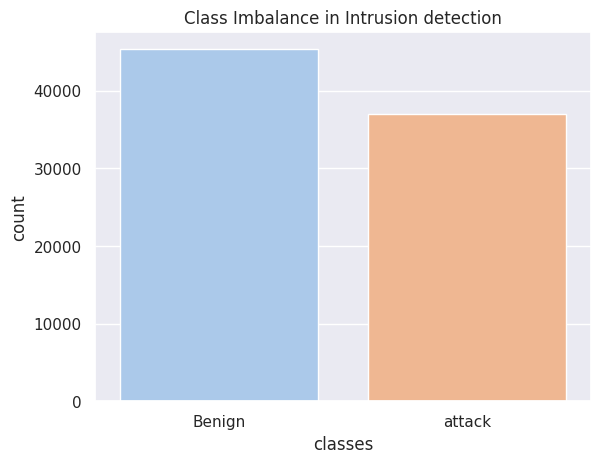

In [ ]:
# Visualise to show level of class imbalance in UNSW-NB15 Dataset.
import seaborn as sns
import matplotlib.pyplot as plt
label_class= df['label'].value_counts()
sns.barplot(x=['Benign','attack',],y=label_class, palette="pastel")
plt.title("Class Imbalance in Intrusion detection")
plt.xlabel('classes')
plt.ylabel('count')
plt.show()

In [ ]:
# Balance the dataset using Synthetic Minority Oversampling technique.
#smt = SMOTE()
# Apply the Synthetic over-sampling technique on the dataset (X and y).
#X_resampled, y_resampled = smt.fit_resample(X, y)

In [ ]:
# Balance the dataset using Random Oversampling technique.
#ros = RandomOverSampler()
# Apply the resampling technique on the dataset (X and y).
#X_resampled, y_resampled = ros.fit_resample(X, y)

In [ ]:
# Balance the dataset using Random Undersampling technique.
rus = RandomUnderSampler(sampling_strategy='auto',
      random_state=0,
      replacement=True )
# Apply the resampling technique on the dataset (X and y).
X_resampled, y_resampled = rus.fit_resample(X, y)

In [ ]:
# Balance the dataset using NearMiss technique.
#nm2 = NearMiss(
 #     sampling_strategy='auto',
  #    version=2)
# Apply the resampling technique on the dataset (X and y).
#X_resampled, y_resampled = nm2.fit_resample(X, y)

In [ ]:
# Balance the dataset using Tomek Links.
#tl = TomekLinks(
 #    sampling_strategy='auto',
  #   n_jobs=4)
# Apply the resampling technique on the dataset (X and y).
#X_resampled, y_resampled = tl.fit_resample(X, y)

In [ ]:
# Add a new column named 'target' to the DataFrame `X_resampled`
X_resampled['label'] = y_resampled

In [ ]:
# Save DataFrame to a CSV file
X_resampled.to_csv("file1.csv")

In [ ]:
# Initiate spark session
spark = SparkSession.builder.appName("Network Attacks Classifier").master("local").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

start = time.time()

In [ ]:
# read the CSV file into a Spark DataFrame
df = spark.read.csv('file1.csv', header = True, inferSchema = True)
df.printSchema()
cols=df.columns

root
 |-- _c0: integer (nullable = true)
 |-- dur: double (nullable = true)
 |-- proto: integer (nullable = true)
 |-- service: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- spkts: integer (nullable = true)
 |-- dpkts: integer (nullable = true)
 |-- sbytes: integer (nullable = true)
 |-- dbytes: integer (nullable = true)
 |-- rate: double (nullable = true)
 |-- sload: double (nullable = true)
 |-- dload: double (nullable = true)
 |-- sloss: integer (nullable = true)
 |-- dloss: integer (nullable = true)
 |-- sinpkt: double (nullable = true)
 |-- dinpkt: double (nullable = true)
 |-- sjit: double (nullable = true)
 |-- djit: double (nullable = true)
 |-- swin: integer (nullable = true)
 |-- stcpb: long (nullable = true)
 |-- dtcpb: long (nullable = true)
 |-- dwin: integer (nullable = true)
 |-- tcprtt: double (nullable = true)
 |-- synack: double (nullable = true)
 |-- ackdat: double (nullable = true)
 |-- smean: integer (nullable = true)
 |-- dmean: integer (nul

In [ ]:
# drop the column 'attack_cat'
df = df.drop('attack_cat')
df.show()

+---+------+-----+-------+-----+-----+-----+------+------+---------+-----------+-----+-----+-----+---------+------+----+----+----+-----+-----+----+------+------+------+-----+-----+-----------+-----------------+----------------+----------------+------------+----------+----------------+---------------+-----+
|_c0|   dur|proto|service|state|spkts|dpkts|sbytes|dbytes|     rate|      sload|dload|sloss|dloss|   sinpkt|dinpkt|sjit|djit|swin|stcpb|dtcpb|dwin|tcprtt|synack|ackdat|smean|dmean|trans_depth|response_body_len|ct_src_dport_ltm|ct_dst_sport_ltm|is_ftp_login|ct_ftp_cmd|ct_flw_http_mthd|is_sm_ips_ports|label|
+---+------+-----+-------+-----+-----+-----+------+------+---------+-----------+-----+-----+-----+---------+------+----+----+----+-----+-----+----+------+------+------+-----+-----+-----------+-----------------+----------------+----------------+------------+----------+----------------+---------------+-----+
|  0|1.1E-5|  117|      0|    4|    2|    0|   496|     0| 90909.09|1.803636

In [ ]:
# Instantiate a 'VectorAssembler` object and transform
sel_cols = df.columns
assembler = VectorAssembler(inputCols = sel_cols, outputCol = "features_vectorize")
data = assembler.transform(df)
data

DataFrame[_c0: int, dur: double, proto: int, service: int, state: int, spkts: int, dpkts: int, sbytes: int, dbytes: int, rate: double, sload: double, dload: double, sloss: int, dloss: int, sinpkt: double, dinpkt: double, sjit: double, djit: double, swin: int, stcpb: bigint, dtcpb: bigint, dwin: int, tcprtt: double, synack: double, ackdat: double, smean: int, dmean: int, trans_depth: int, response_body_len: int, ct_src_dport_ltm: int, ct_dst_sport_ltm: int, is_ftp_login: int, ct_ftp_cmd: int, ct_flw_http_mthd: int, is_sm_ips_ports: int, label: int, features_vectorize: vector]

In [ ]:
# Select distinct values from the "label" column, order them in ascending order,
# and then collect the values into a list.
label_list = data.select(["label"]).distinct().orderBy("label").rdd.flatMap(lambda x: x).collect()

In [ ]:
# Quick inspection of the data using the first 5 rows
pd.DataFrame(data.take(5),columns=data.columns)

,_c0,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,label,features_vectorize
0,0,0.000011,117,0,4,2,0,496,0,90909.09,...,0,0,1,1,0,0,0,0,0,"(0.0, 1.1e-05, 117.0, 0.0, 4.0, 2.0, 0.0, 496...."
1,1,0.000008,117,0,4,2,0,1762,0,125000.00,...,0,0,1,1,0,0,0,0,0,"(1.0, 8e-06, 117.0, 0.0, 4.0, 2.0, 0.0, 1762.0..."
2,2,0.000005,117,0,4,2,0,1068,0,200000.00,...,0,0,1,1,0,0,0,0,0,"(2.0, 5e-06, 117.0, 0.0, 4.0, 2.0, 0.0, 1068.0..."
3,3,0.000006,117,0,4,2,0,900,0,166666.66,...,0,0,2,1,0,0,0,0,0,"(3.0, 6e-06, 117.0, 0.0, 4.0, 2.0, 0.0, 900.0,..."
4,4,0.000010,117,0,4,2,0,2126,0,100000.00,...,0,0,2,1,0,0,0,0,0,"(4.0, 1e-05, 117.0, 0.0, 4.0, 2.0, 0.0, 2126.0..."


In [ ]:
# Split the dataset into training and testing sets
train, test = data.randomSplit([0.8, 0.2], seed = 12)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 58941
Test Dataset Count: 15059


In [ ]:
# Group by 'label' column and count number of occurences
# Convert to a Pandas DataFrame for easier manipulation.
train_label=train.groupBy('label').count().toPandas()
test_label=test.groupBy('label').count().toPandas()

In [ ]:
# Initialise Logistic Regression model with specified hyperparameters
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0.8, featuresCol = 'features_vectorize',
                        labelCol = 'label', family="multinomial")

# Initialise Decision Tree model
dt = DecisionTreeClassifier(featuresCol = 'features_vectorize', labelCol = 'label')

# Initialise Random Forest model with 20 trees
rf = RandomForestClassifier(labelCol='label', featuresCol='features_vectorize', numTrees=20)

# Initialise Naive Bayes Multinomial model
nb = NaiveBayes(labelCol='label', featuresCol='features_vectorize', smoothing=1.0, modelType="multinomial")

# Store models in a dictionary for easier iteration
classifiers = {"Logistic Regression": lr, "Decision Tree": dt,
               "Random Forest": rf, "Naive Bayes Multinomial": nb}

# Define evaluation metrics to be computed for each model
metrics = ["accuracy", "weightedPrecision", "weightedRecall", "f1"]

print("\nModels Evaluation:")
print("{:-<24}".format(""))


Models Evaluation:
------------------------


Logistic Regression
now running Logistic Regression model
accuracy = 1.00
weightedPrecision = 1.00
weightedRecall = 1.00
f1 = 1.00
Decision Tree
now running Decision Tree model
accuracy = 1.00
weightedPrecision = 1.00
weightedRecall = 1.00
f1 = 1.00
Random Forest
now running Random Forest model
accuracy = 1.00
weightedPrecision = 1.00
weightedRecall = 1.00
f1 = 1.00
Naive Bayes Multinomial
now running Naive Bayes Multinomial model
accuracy = 0.76
weightedPrecision = 0.77
weightedRecall = 0.76
f1 = 0.76


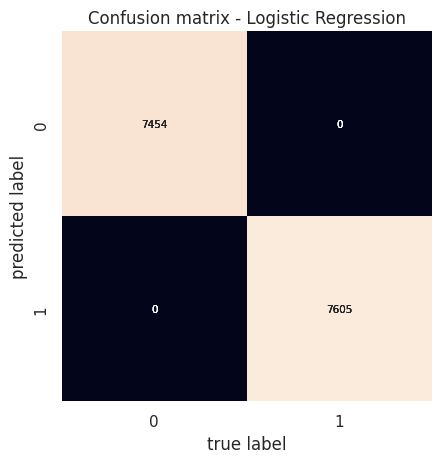

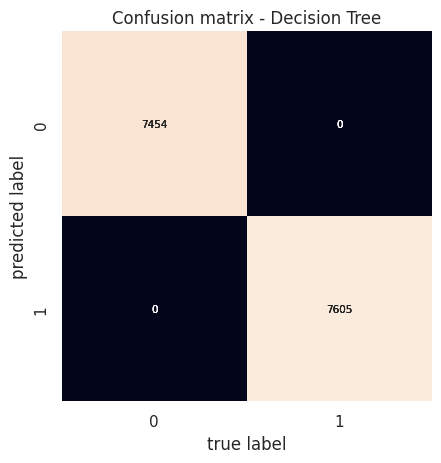

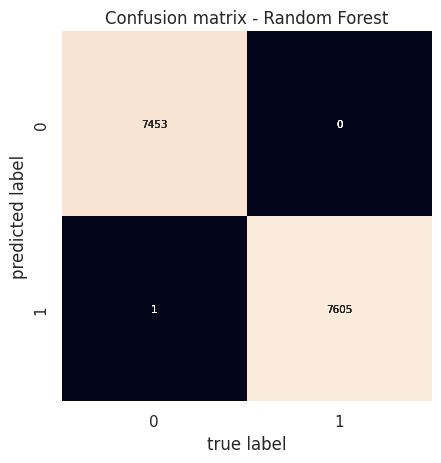

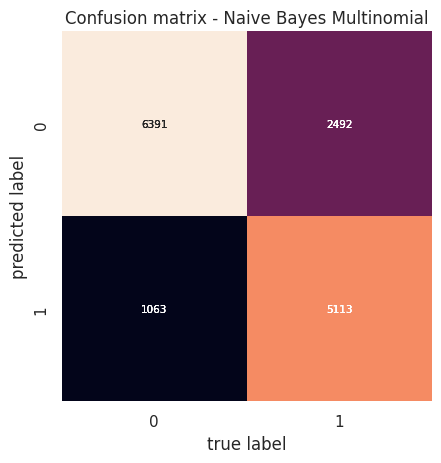

In [ ]:
# Iterate through each classifier
for idx, c in enumerate(classifiers):
  print(c)
	# Fit the model on the training data
  print(f'now running {c} model')
  model = classifiers[c].fit(train)

  # Use the trained model to make predictions on the test data
  predictions = model.transform(test)
  predictions.cache()

  # Evaluate the performance of the model using PySpark's MulticlassClassificationEvaluator
  evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol="prediction")
  for m in metrics:
    evaluator.setMetricName(m)
    metric = evaluator.evaluate(predictions)
    print("{name} = {value:.2f}".format(name=m, value=metric))

    # Build confusion matrix using Scikit-learn (sktlearn)
    target_list = predictions.select('label').rdd.flatMap(lambda x: x).collect()
    pred_list = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
    label_num_list = predictions.select('label').distinct().orderBy('label').rdd.flatMap(lambda x: x).collect()
    # print("\nClassification report using Sklearn:")
    # print(classification_report(target_list, pred_list, target_names=label_list))

    # Compute and visualize the confusion matrix using seaborn
    conf_matrix = confusion_matrix(target_list, pred_list)
    plt.figure(idx)
    plt.title("Confusion matrix - {model}".format(model=c))
    sns.heatmap(conf_matrix.T, square=True, annot=True, fmt='d', cbar=False,
	            annot_kws={"size": 7.5}, xticklabels=label_list, yticklabels=label_list)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.draw()
    plt.tight_layout()

# Display all the confusion matrix plots
plt.show()